In [2]:
import penemuu
import glob
import json
import spacy
import json
import pandas as pd

import en_core_web_sm
import en_core_web_md
#import en_core_web_lg
from spacy.pipeline import EntityRuler
from spacy import displacy
from penemuu import TestFunctions
from penemuu import DependencyMapper

from collections import defaultdict
from collections import Counter

from itertools import product

import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

Generate corpus of biomedical abstracts annotated with named entities (bacterial species and habitats)
and extract sentences that contain at least one entity of each type.

In [3]:
"""
Pubmed files were downloaded using easy_pubmed_batch_downloads.R (easyPubMed R library) with a query
for "foodborne bacterial infections".

Each file contains 100 entries in MedLine format.

Available titles and/or abstracts are extracted from each entry, combined, and used to populate a 
PassageCorpus object.
"""
pubmed_files = glob.glob('resources/pubmed/bacteria_foodborne_disease_200115/*txt')
corpus = penemuu.PassageCorpus()

for file in pubmed_files:
    corpus.add_medline_records_from_file(file)

In [4]:
"""
jsonl file for entity ruler was generated from NCBI taxonomy dump file (2/21) (bacteria) and BioNLP 
bacterial biotope .obo reference file (habitats).

PassageAnnotator contains a spaCy pipeline with an EntityRuler derived from the jsonl file.
"""
jsonl = 'resources/entity_ruler_bacteria_habitat_200130.jsonl'

annotator = penemuu.PassageAnnotator(lang_model_to_use='en_core_web_md')
annotator.add_entity_ruler_from_jsonl(jsonl)

Entity ruler generated from jsonl at resources/entity_ruler_bacteria_habitat_200130.jsonl
Entity ruler added to spacy pipeline.
PySBDFactory added to spacy pipeline.


In [5]:
"""
Text passages are annotated for named entities and sentences containing at least 1 entity of each type are
extracted and written to a file.
"""    
outfile = 'resources/test_sentences_with_bac_and_hab_ents_200211.txt'
sentences_with_entities = TestFunctions.get_single_sentences_with_entities_by_labels(corpus, annotator, ['BACTERIA', 'HABITAT'], outfile)

"""
Filtering sentences to those with a root that is a verb or auxiliary verb eliminates titles (which are 
often not full sentences) and sentence fragments due to sentence boundary detection errors.
"""

'\nFiltering sentences to those with a root that is a verb or auxiliary verb eliminates titles (which are \noften not full sentences) and sentence fragments due to sentence boundary detection errors.\n'

In [6]:
"""
Separating full and non-full sentences.

Full sentences require:
    -A verb.
    -A subject.

Non-full sentences in text passages are the result of:
    -Paper titles, which are frequently incomplete sentences.
    -Sentence boundary detection errors, often resulting from the ubiquitous use of abbreviations in biomedical
    abstracts.
    -Genuinely incomplete sentences.

Paper titles:
    The logical fix for this is to handle titles and abstracts separately.  My intuition is that a title containing
    two named entities will almost always be positively linking the two.  To be added.

Sentence boundary detection:
    PassageAnnotator includes a PySBDFactory component (https://spacy.io/universe/project/python-sentence-boundary-disambiguation).
    I will manually add more scientific abbreviations to its abbrev. list as I encounter them.

Incomplete sentences:
    These seem to throw off spaCy dependency parsing in unpredictable ways
    
"""

full_sentences = []
sentences_without_verbs = []
sentences_with_verbs_without_subjs = []

for sent in sentences_with_entities:
    
    #Verb detection
    
    sent_verbs = ([i for i in filter(lambda w: w.pos_ in ['VERB', 'AUX'], sent)])

    if sent_verbs and sent.root.pos_ in ['VERB', 'AUX']:
        
        #Subject detection
        sent_subjs = ([i for i in filter(lambda w: w.dep_ in ['nsubj', 'nsubjpass', 'csubj'], sent)])
        if sent_subjs:
            full_sentences.append(sent)
        else:
            sentences_with_verbs_without_subjs.append(sent)

    else:
        sentences_without_verbs.append(sent)
        

In [6]:
"""
Sentences without verbs are mostly short fragments.

Even ones that appear very clear could be misleading without context:

"c. jejuni in the farm environment.,"

Is not useful without knowing if it's preceded by:

"Thousands of samples corroborated..."
or:
"Thousands of samples failed to corroborate..."

These may still be useful when looking at the abstract as a whole.
"""

sentences_without_verbs[:10]

[on-farm strategies to control and reduce e. coli,
 very high c. jejuni load in their gastrointestinal tract, especially the ceca.,
 thirty-five of staphylococcus aureus isolated from food raw materials and workers' hands in a noshery were characterized using antibiotic susceptibility testing, enterobacterial repetitive intergenic consensus-polymerase chain reaction (eric-pcr), and random amplified polymorphic dna (rapd)-pcr.,
 s. aureus and tracing the sources of it from the food chain.,
 escherichia coli o157:h7 is a significant human pathogen which has mostly foodborne and waterborne modes of transmission.,
 12 e. coli o157:h7 isolates that possess the same two-enzyme pulsed-field gel electrophoresis (pfge) profile and are related temporally or geographically to the above outbreak.,
 s. aureus and bovine mastitis caused by,
 s. aureus isolates associated with cases of sfp with isolates obtained from bovine mastitis milk and pig carcasses.,
 100 s. aureus isolates: 20 isolates relate

In [7]:
"""
Sentences with verbs but no subjects are trickier.

Some are incoherent fragments:
    "b. pinnipedialis dna to verify brucella detection by the is 711 primer-probe within fish dna."

Others are coherent but have overly passive voice:
    "e. coli (escherichia coli o157:h7-gfp b6-914), salmonella (salmonella enterica serovar enteritidis phage-type pt21), 
    and the gram-positive bacteria listeria (listeria innocua), as well as environmental microorganisms 
    derived from local river water."
    
The latter may be usable, but may be tricky to separate from the former.
    
"""

print("Sentence:")
print(sentences_with_verbs_without_subjs[0])

print("\nRoot:")
print(sentences_with_verbs_without_subjs[0].root)

displacy.render(sentences_with_verbs_without_subjs[0])

Sentence:
c. perfringens type a food poisoning (fp) and nonfood-borne (nfb) human gastrointestinal diseases.

Root:
type


In [8]:
verbs_used = []
verb_tokens_used = []
verb_lemmas_used = []
for sent in full_sentences:
    
    if sent.root.pos_ in ['VERB', 'AUX']:
        verbs_used.append(sent.root.text)
        verb_tokens_used.append(sent.root)
        verb_lemmas_used.append(sent.root.lemma_)
    elif sent.root.pos_ not in ['NOUN', 'PROPN']:
        print(sent)
        print(sent.root, sent.root.pos_)

In [9]:
print("Number of abstracts: %d" % len(corpus.text_passages))

print("Number of sentences with entity pairs: %d" % len(sentences_with_entities))

print("Number of sentences with entities and verb roots: %d" % len(verbs_used))

counted_verbs_used = Counter(verbs_used).most_common()
print("Number of distinct verbs used: %d" % len(counted_verbs_used))

verbs_used_once = ([i for i in counted_verbs_used if i[1] == 1])
print("Number of verbs used in only 1 sentence: %d" % len(verbs_used_once))
counted_verb_lemmas_used = Counter(verb_lemmas_used).most_common()
print("Number of distinct verb lemmas used: %d" % len(counted_verb_lemmas_used))

lemmas_used_once = ([i for i in counted_verb_lemmas_used if i[1] == 1])
print("Number of verb lemmas used in only 1 sentence: %d" % len(lemmas_used_once))



Number of abstracts: 7134
Number of sentences with entity pairs: 7044
Number of sentences with entities and verb roots: 5681
Number of distinct verbs used: 772
Number of verbs used in only 1 sentence: 383
Number of distinct verb lemmas used: 484
Number of verb lemmas used in only 1 sentence: 199


Text(0, 0.5, 'Verbs')

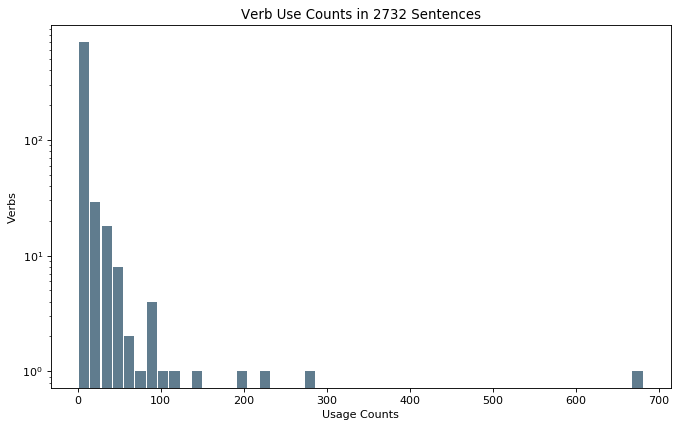

In [10]:
counted_verb_array = np.array(counted_verbs_used)
counted_verb_series = pd.Series([int(i) for i in counted_verb_array[:, 1]])

fig=plt.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k')
counted_verb_series.plot.hist(grid=False, bins=50, rwidth=0.9,
                   color='#607c8e')
plt.title('Verb Use Counts in 2732 Sentences')
plt.yscale('log')
plt.xlabel('Usage Counts')
plt.ylabel('Verbs')

Text(0, 0.5, 'Verb Lemmas')

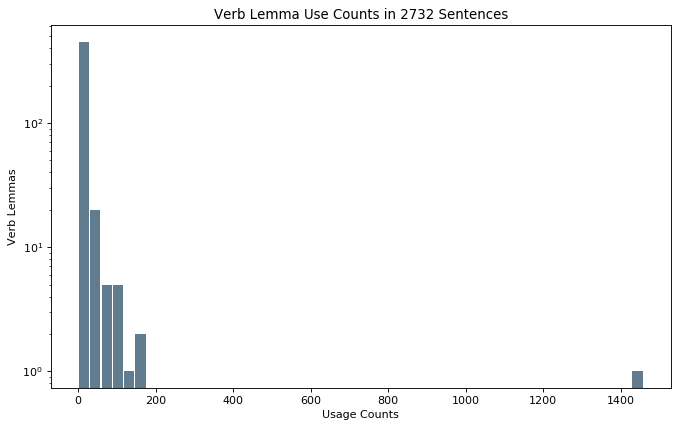

In [11]:
counted_verb_lemmas_array = np.array(counted_verb_lemmas_used)
counted_verb_lemmas_series = pd.Series([int(i) for i in counted_verb_lemmas_array[:, 1]])

fig=plt.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k')
counted_verb_lemmas_series.plot.hist(grid=False, bins=50, rwidth=0.9,
                   color='#607c8e')
plt.title('Verb Lemma Use Counts in 2732 Sentences')
plt.yscale('log')
plt.xlabel('Usage Counts')
plt.ylabel('Verb Lemmas')

In [12]:
def generate_verb_span_from_sent_span(nlp, sent_span):
    verbs = [token.text for token in sent_span if token.pos_ in ['VERB', 'AUX']]
    verb_span = nlp(' '.join(verbs))
    return verb_span

def filter_sentences_by_root_lemmas(sentences, lemma_texts):
    
    filtered_sentences = {}
    for sentence in sentences:
        if sentence.root.lemma_ in lemma_texts:
            filtered_sentences.setdefault(sentence.root.lemma_, []).append(sentence)
    
    print("Number of sentences with each root lemma:")
    for lemma, sentences in filtered_sentences.items():
        print(lemma, len(sentences))
    
    return filtered_sentences
    

In [13]:
common_root_lemmas = [i[0] for i in counted_verb_lemmas_used[:25]]

root_lemma_sentences_dict =  filter_sentences_by_root_lemmas(full_sentences, common_root_lemmas)

lemma_filtered_sentences_dir = 'resources/filtered_lemma_sentences/'

for lemma, sentences in root_lemma_sentences_dict.items():
    
    lemma_filtered_text_file = '%s%s.txt' % (lemma_filtered_sentences_dir, lemma)
    with open(lemma_filtered_text_file, 'w') as f:
        for sentence in sentences:
            f.write('%s\n' % sentence)

Number of sentences with each root lemma:
be 1458
show 151
identify 121
indicate 85
cause 98
demonstrate 71
determine 43
suggest 80
detect 96
have 67
occur 45
use 116
examine 53
collect 45
report 105
isolate 152
reveal 56
investigate 96
describe 56
provide 50
find 88
evaluate 51
conduct 52
associate 58
test 56


In [1]:

dep_mapper = DependencyMapper()

master_verb_component_dict = {}

#All full sentences (subj + obj + verb root + 1 or more instances of BACTERIA + 1 or more instances of HABITAT)
component_breakdown_dict = dep_mapper.get_component_breakdown_from_sentences(full_sentences, 'BACTERIA', 'HABITAT')
component_breakdown_counts_dict = get_component_breakdown_counts(component_breakdown_dict, percentage_flag=False)
master_verb_component_dict['total_counts'] = component_breakdown_counts_dict
component_breakdown_counts_dict = get_component_breakdown_counts(component_breakdown_dict, percentage_flag=True)
master_verb_component_dict['total_percentages'] = component_breakdown_counts_dict

#Breakdowns of 25 most common root lemmas
for root_lemma in common_root_lemmas:
    component_breakdown_dict = get_component_breakdown_from_sentences(root_lemma_sentences_dict[root_lemma], 'BACTERIA', 'HABITAT')
    component_breakdown_counts_dict = get_component_breakdown_counts(component_breakdown_dict)
    master_verb_component_dict['%s_counts' % root_lemma] = component_breakdown_counts_dict
    
    component_breakdown_counts_dict = get_component_breakdown_counts(component_breakdown_dict, percentage_flag=True)
    master_verb_component_dict['%s_percentages' % root_lemma] = component_breakdown_counts_dict


NameError: name 'DependencyMapper' is not defined

In [59]:
master_verb_component_df = pd.DataFrame.from_dict(master_verb_component_dict)

master_count_df = master_verb_component_df.filter(regex='counts').transpose()
master_count_df['verb'] = [i.split('_')[0] for i in master_count_df.index.tolist()]

master_percentages_df = master_verb_component_df.filter(regex='percentages').transpose()
master_percentages_df['verb'] = [i.split('_')[0] for i in master_count_percentages_df.index.tolist()]

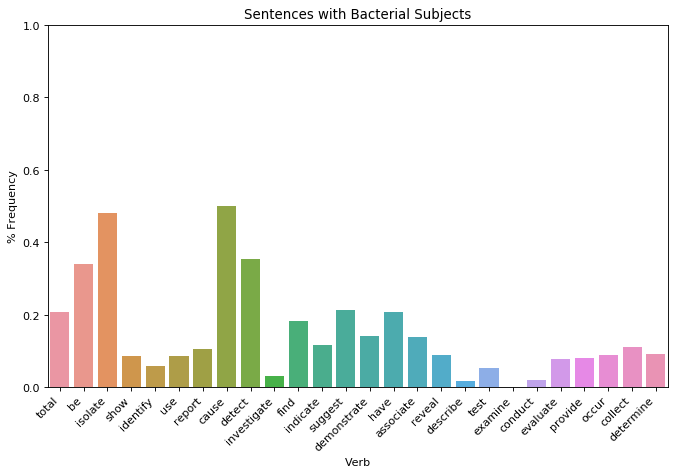

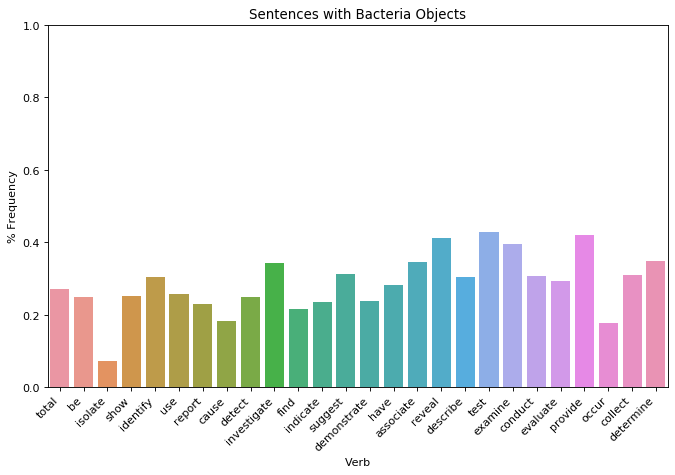

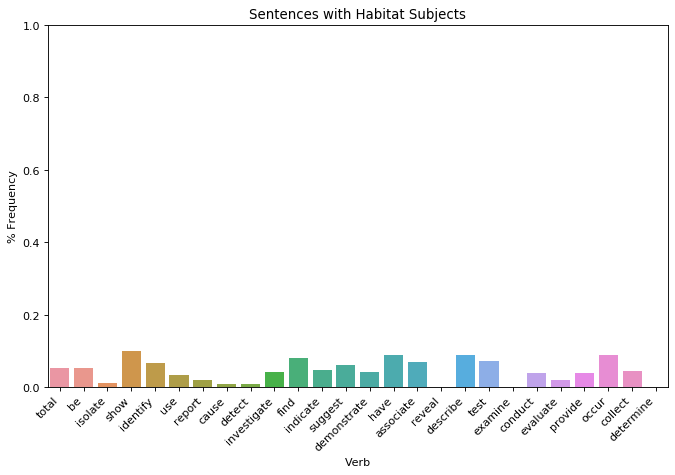

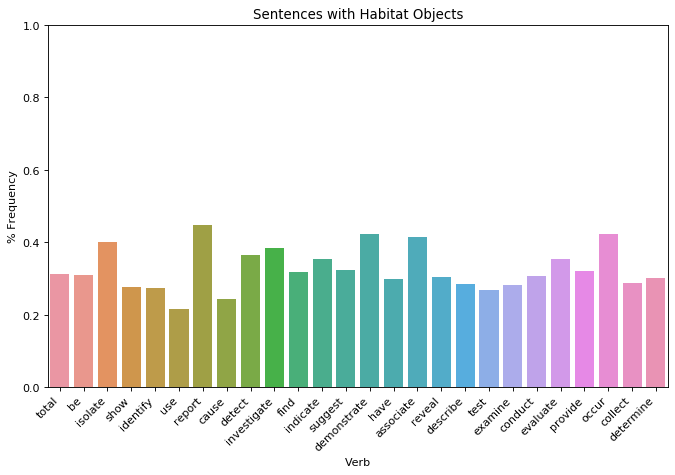

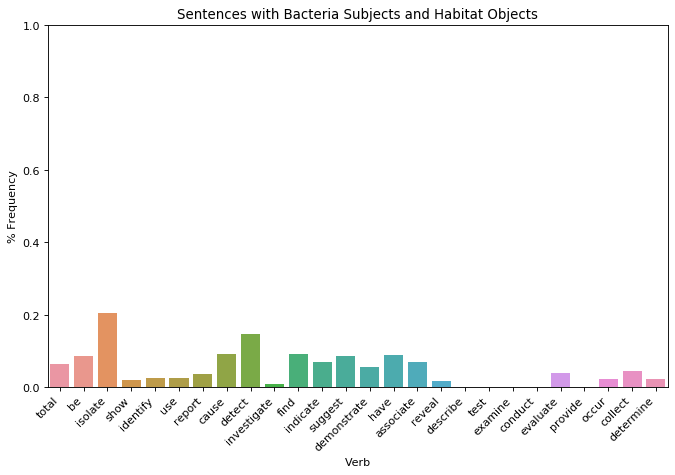

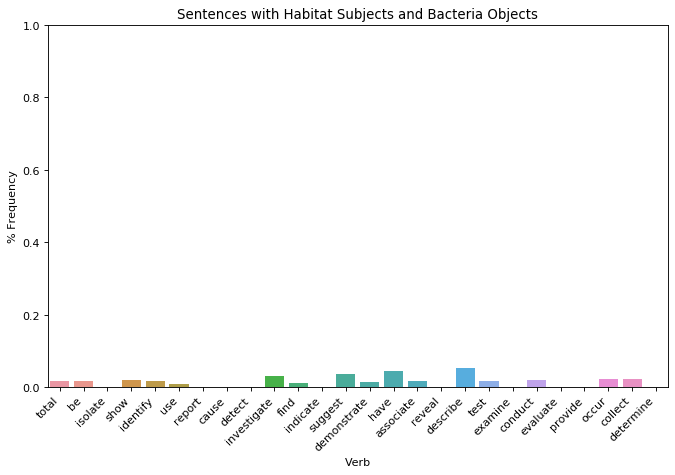

In [180]:
sentence_type_readable_dict = {
    'bacteria_subj_sents' : "Sentences with Bacterial Subjects",
    'bacteria_obj_sents' : "Sentences with Bacteria Objects",
    'habitat_subj_sents' : "Sentences with Habitat Subjects",
    'habitat_obj_sents' : "Sentences with Habitat Objects",
    'bacteria_subj_habitat_obj_sents': "Sentences with Bacteria Subjects and Habitat Objects",
    'habitat_subj_bacteria_obj_sents' : "Sentences with Habitat Subjects and Bacteria Objects"
}

for sentence_type, readable in sentence_type_readable_dict.items():
    fig=plt.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k')
    fig=plt.ylim(0.0, 1.0)

    chart=sns.barplot(x="verb", y=sentence_type, data=master_percentages_df)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
    chart.set_title(readable)
    chart.set_xlabel("Verb")
    chart.set_ylabel('% Frequency')
    fig=chart.get_figure()
    fig.savefig('%s.png' %sentence_type)

In [184]:
heatmap_df = master_percentages_df.drop(['sentences'], axis=1).set_index('verb').transpose()
heatmap_df['Sentence Type'] = [sentence_type_readable_dict[i] for i in heatmap_df.index]
heatmap_df = heatmap_df.set_index('Sentence Type')


0.43676999735366184

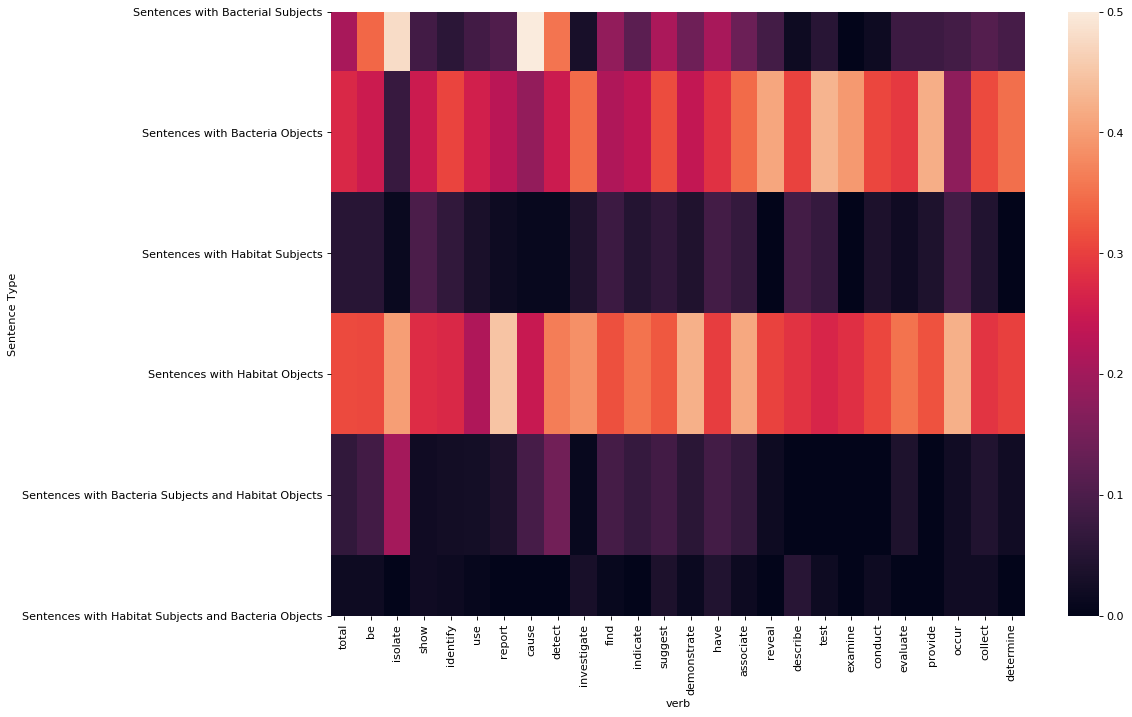

In [186]:
fig=plt.figure(figsize=(14, 10), dpi= 80, facecolor='w', edgecolor='k')

chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set_ylabel("fsaf")
chart=sns.heatmap(heatmap_df)
fig=chart.get_figure()
fig.savefig('verb_sentence_type_freq_heatmap.png')



In [204]:
lemma_sim_array = np.zeros([len(common_root_lemmas), len(common_root_lemmas)])

i = 0
for root_lemma_1 in common_root_lemmas:
    j = 0
    for root_lemma_2 in common_root_lemmas:
        lemma_sim_array[i][j] = annotator.nlp(root_lemma_1).similarity(annotator.nlp(root_lemma_2))
        j += 1
    i += 1

In [208]:
pd.DataFrame(lemma_sim_array, index=common_root_lemmas, columns=common_root_lemmas)

,be,isolate,show,identify,use,report,cause,detect,investigate,find,...,reveal,describe,test,examine,conduct,evaluate,provide,occur,collect,determine
be,1.000000,0.195082,0.526056,0.468198,0.534320,0.385880,0.579572,0.335428,0.322496,0.516736,...,0.400351,0.468228,0.368881,0.368544,0.419070,0.349211,0.541033,0.506997,0.356860,0.537907
isolate,0.195082,1.000000,0.107423,0.521180,0.271580,0.117288,0.320453,0.509351,0.365551,0.230890,...,0.323942,0.343115,0.284707,0.416738,0.249930,0.418785,0.293665,0.298249,0.253325,0.421533
show,0.526056,0.107423,1.000000,0.336713,0.304819,0.378871,0.394330,0.238364,0.301017,0.418615,...,0.491373,0.400559,0.324834,0.346384,0.306437,0.261041,0.316686,0.297413,0.245776,0.374513
identify,0.468198,0.521180,0.336713,1.000000,0.477883,0.451650,0.416982,0.639864,0.638586,0.545464,...,0.515729,0.644103,0.397609,0.729229,0.499239,0.728136,0.542353,0.452863,0.526374,0.763221
use,0.534320,0.271580,0.304819,0.477883,1.000000,0.279504,0.435704,0.418804,0.335763,0.511149,...,0.269361,0.471158,0.418884,0.389278,0.392079,0.437589,0.566877,0.341229,0.404889,0.476163
report,0.385880,0.117288,0.378871,0.451650,0.279504,1.000000,0.322165,0.276574,0.476224,0.338337,...,0.352645,0.369758,0.388187,0.505192,0.438876,0.433772,0.363835,0.277615,0.280640,0.437513
cause,0.579572,0.320453,0.394330,0.416982,0.435704,0.322165,1.000000,0.436770,0.337659,0.402336,...,0.330028,0.430417,0.344417,0.346476,0.346286,0.298347,0.340222,0.626108,0.303455,0.446840
detect,0.335428,0.509351,0.238364,0.639864,0.418804,0.276574,0.436770,1.000000,0.468738,0.326275,...,0.407554,0.360372,0.493656,0.484162,0.341339,0.500889,0.344173,0.442984,0.366239,0.578385
investigate,0.322496,0.365551,0.301017,0.638586,0.335763,0.476224,0.337659,0.468738,1.000000,0.446777,...,0.525341,0.507780,0.291653,0.762964,0.594492,0.644695,0.400558,0.316498,0.469263,0.628685
find,0.516736,0.230890,0.418615,0.545464,0.511149,0.338337,0.402336,0.326275,0.446777,1.000000,...,0.413884,0.487130,0.337259,0.499780,0.280364,0.425028,0.535115,0.267761,0.445257,0.512752


In [101]:
"""
Full sentence and sentence root similarity
"""

n_dim = 250

sent_sim_array = np.zeros((n_dim, n_dim))
root_sim_array = np.zeros((n_dim, n_dim))

i = 0 
for sent_1 in full_sentences[:n_dim]:
    j = 0
    
    for sent_2 in full_sentences[:n_dim]:
        sent_sim_array[i][j] = sent_1.similarity(sent_2)
        root_sim_array[i][j] = sent_1.root.similarity(sent_2.root)
            
        j += 1
    i += 1

In [75]:
"""
Sentence verb similarity
"""

verb_spans = []

for sent in full_sentences[:n_dim]:    
    verb_spans.append(generate_verb_span_from_sent_span(annotator.nlp, sent))

verb_sim_array = np.zeros((n_dim, n_dim))

i = 0 
for verb_span_1 in verb_spans[:n_dim]:
    j = 0
    for verb_span_2 in verb_spans[:n_dim]:
        verb_sim_array[i][j] = verb_span_1.similarity(verb_span_2)   
        j += 1
    i += 1

In [67]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 200

Sentence similarity by average token similarity.


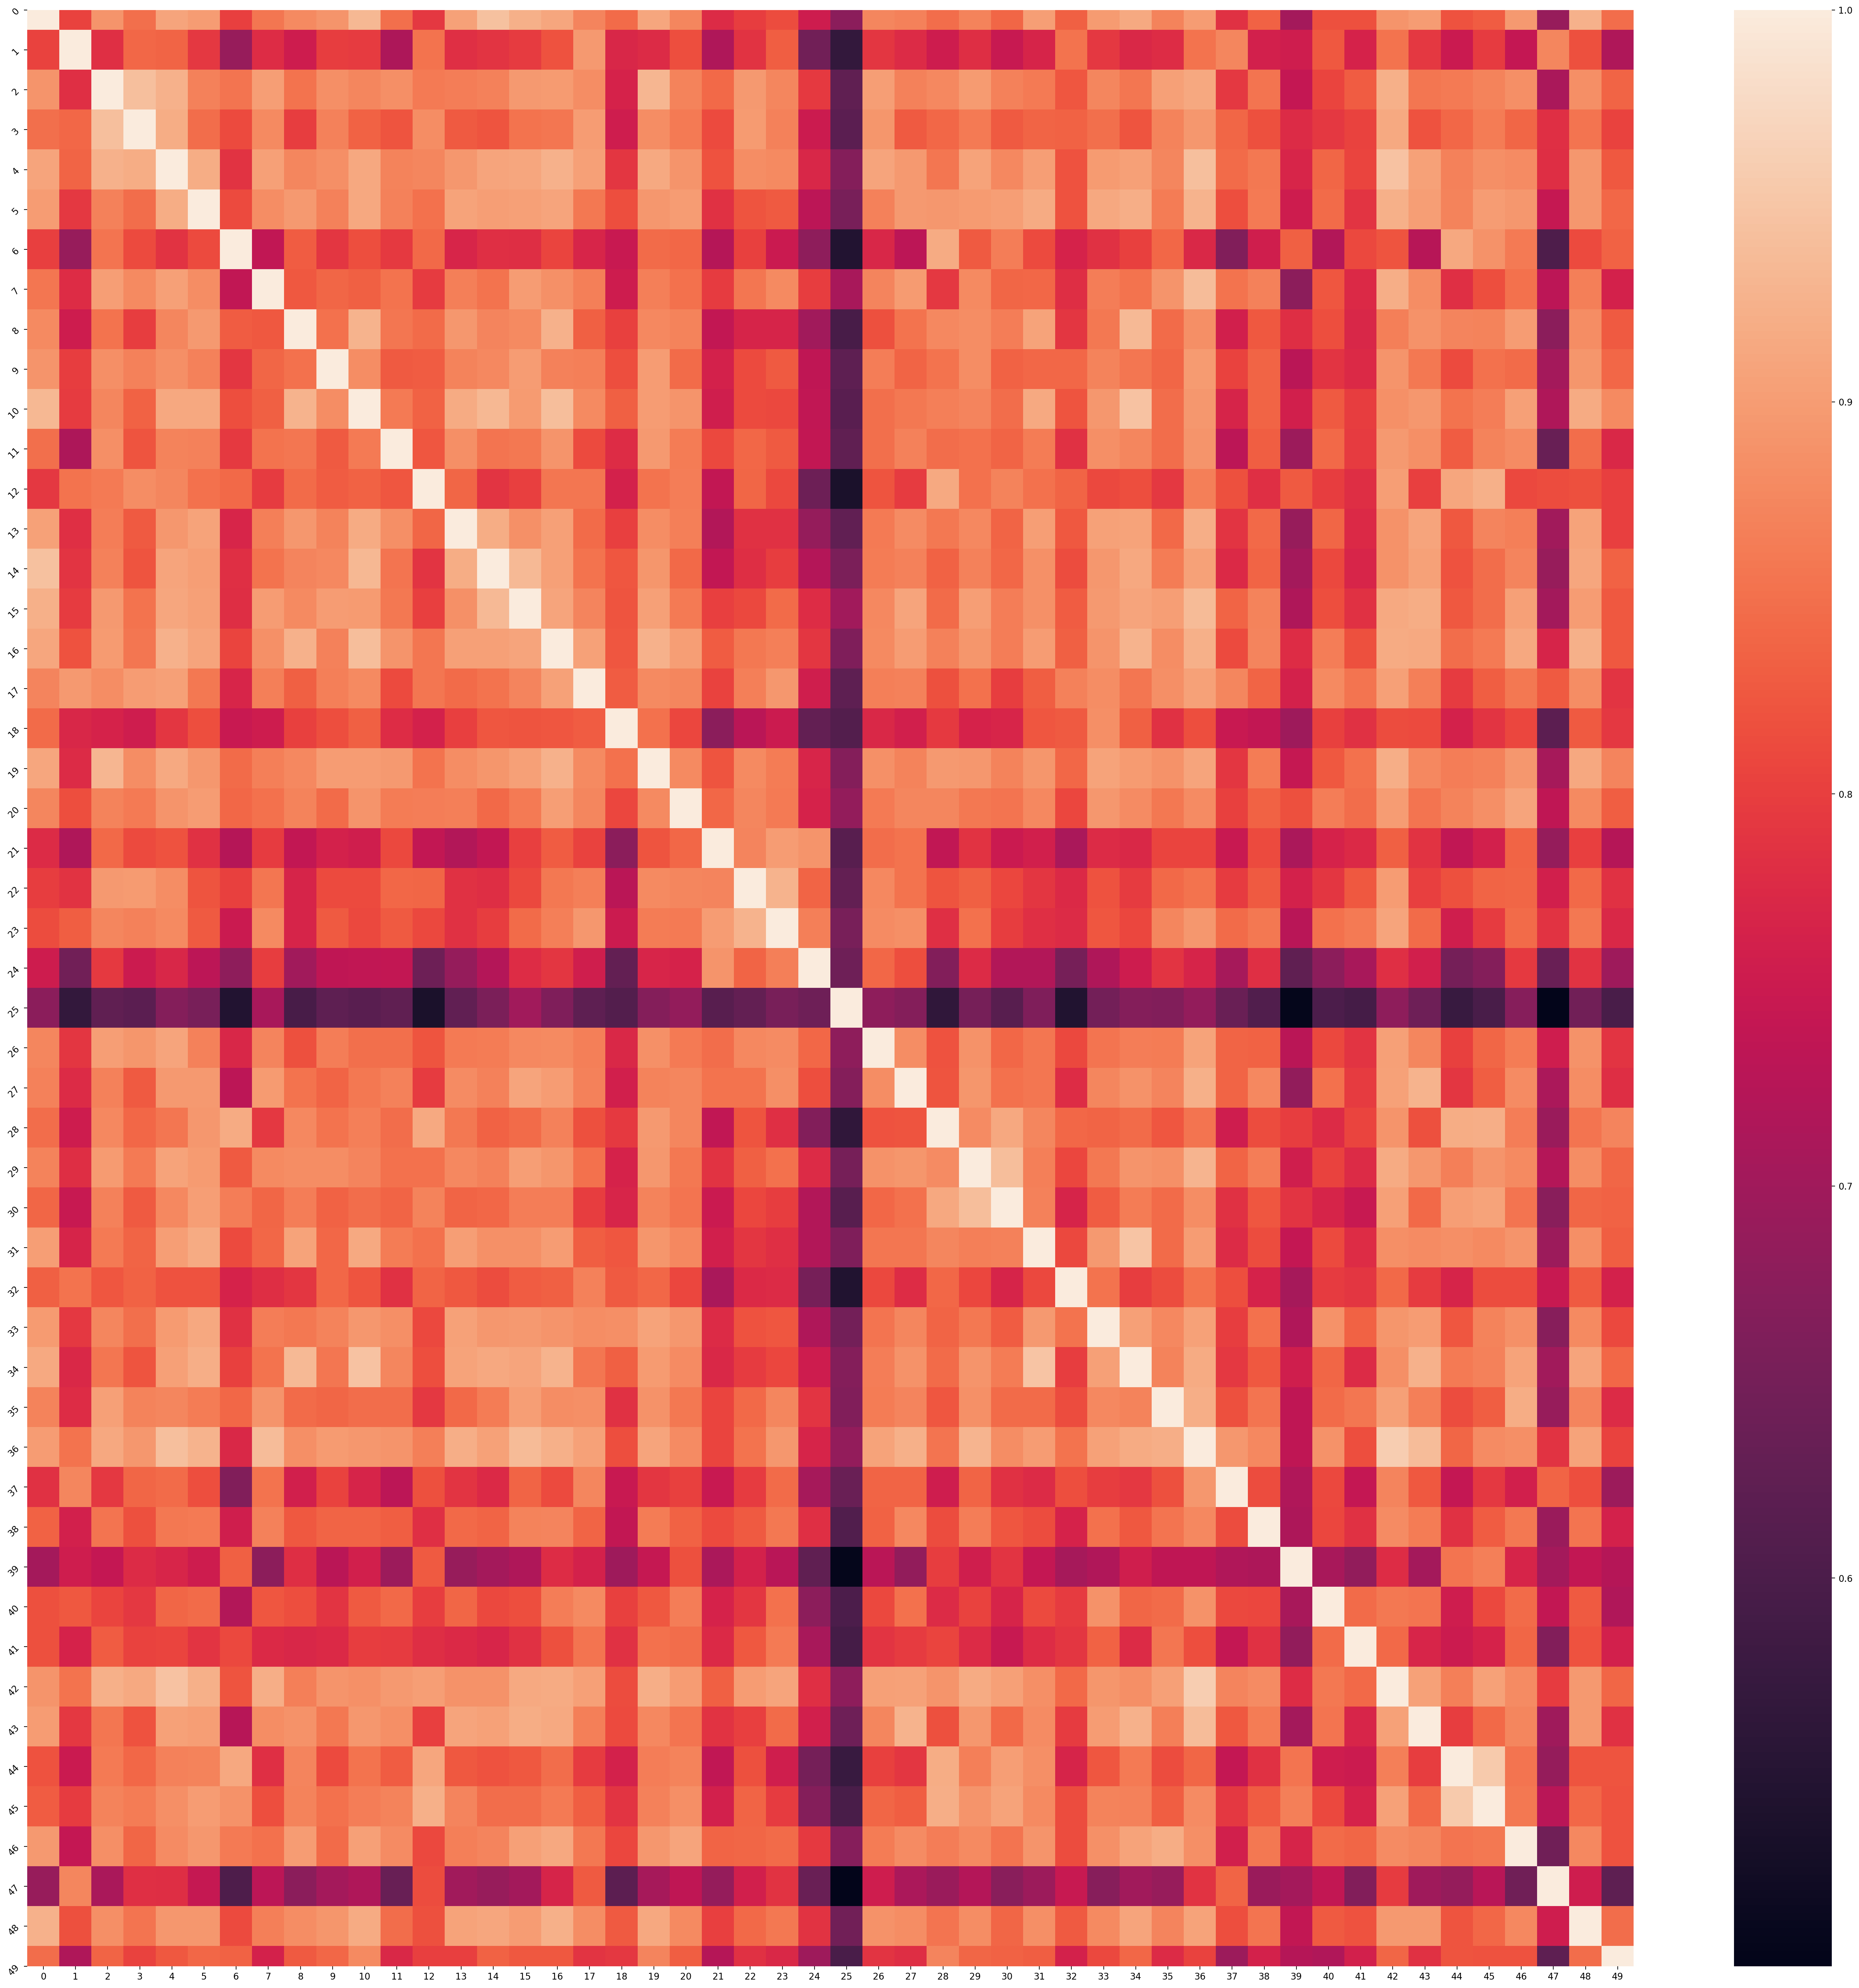

In [68]:
print("Sentence similarity by average token similarity.")

plt.figure(figsize=(40, 40))
ax = sns.heatmap(sent_sim_array, xticklabels=1, yticklabels=1)
plt.yticks(rotation=45)

plt.show()

Sentence similarity by root embedding vectors.


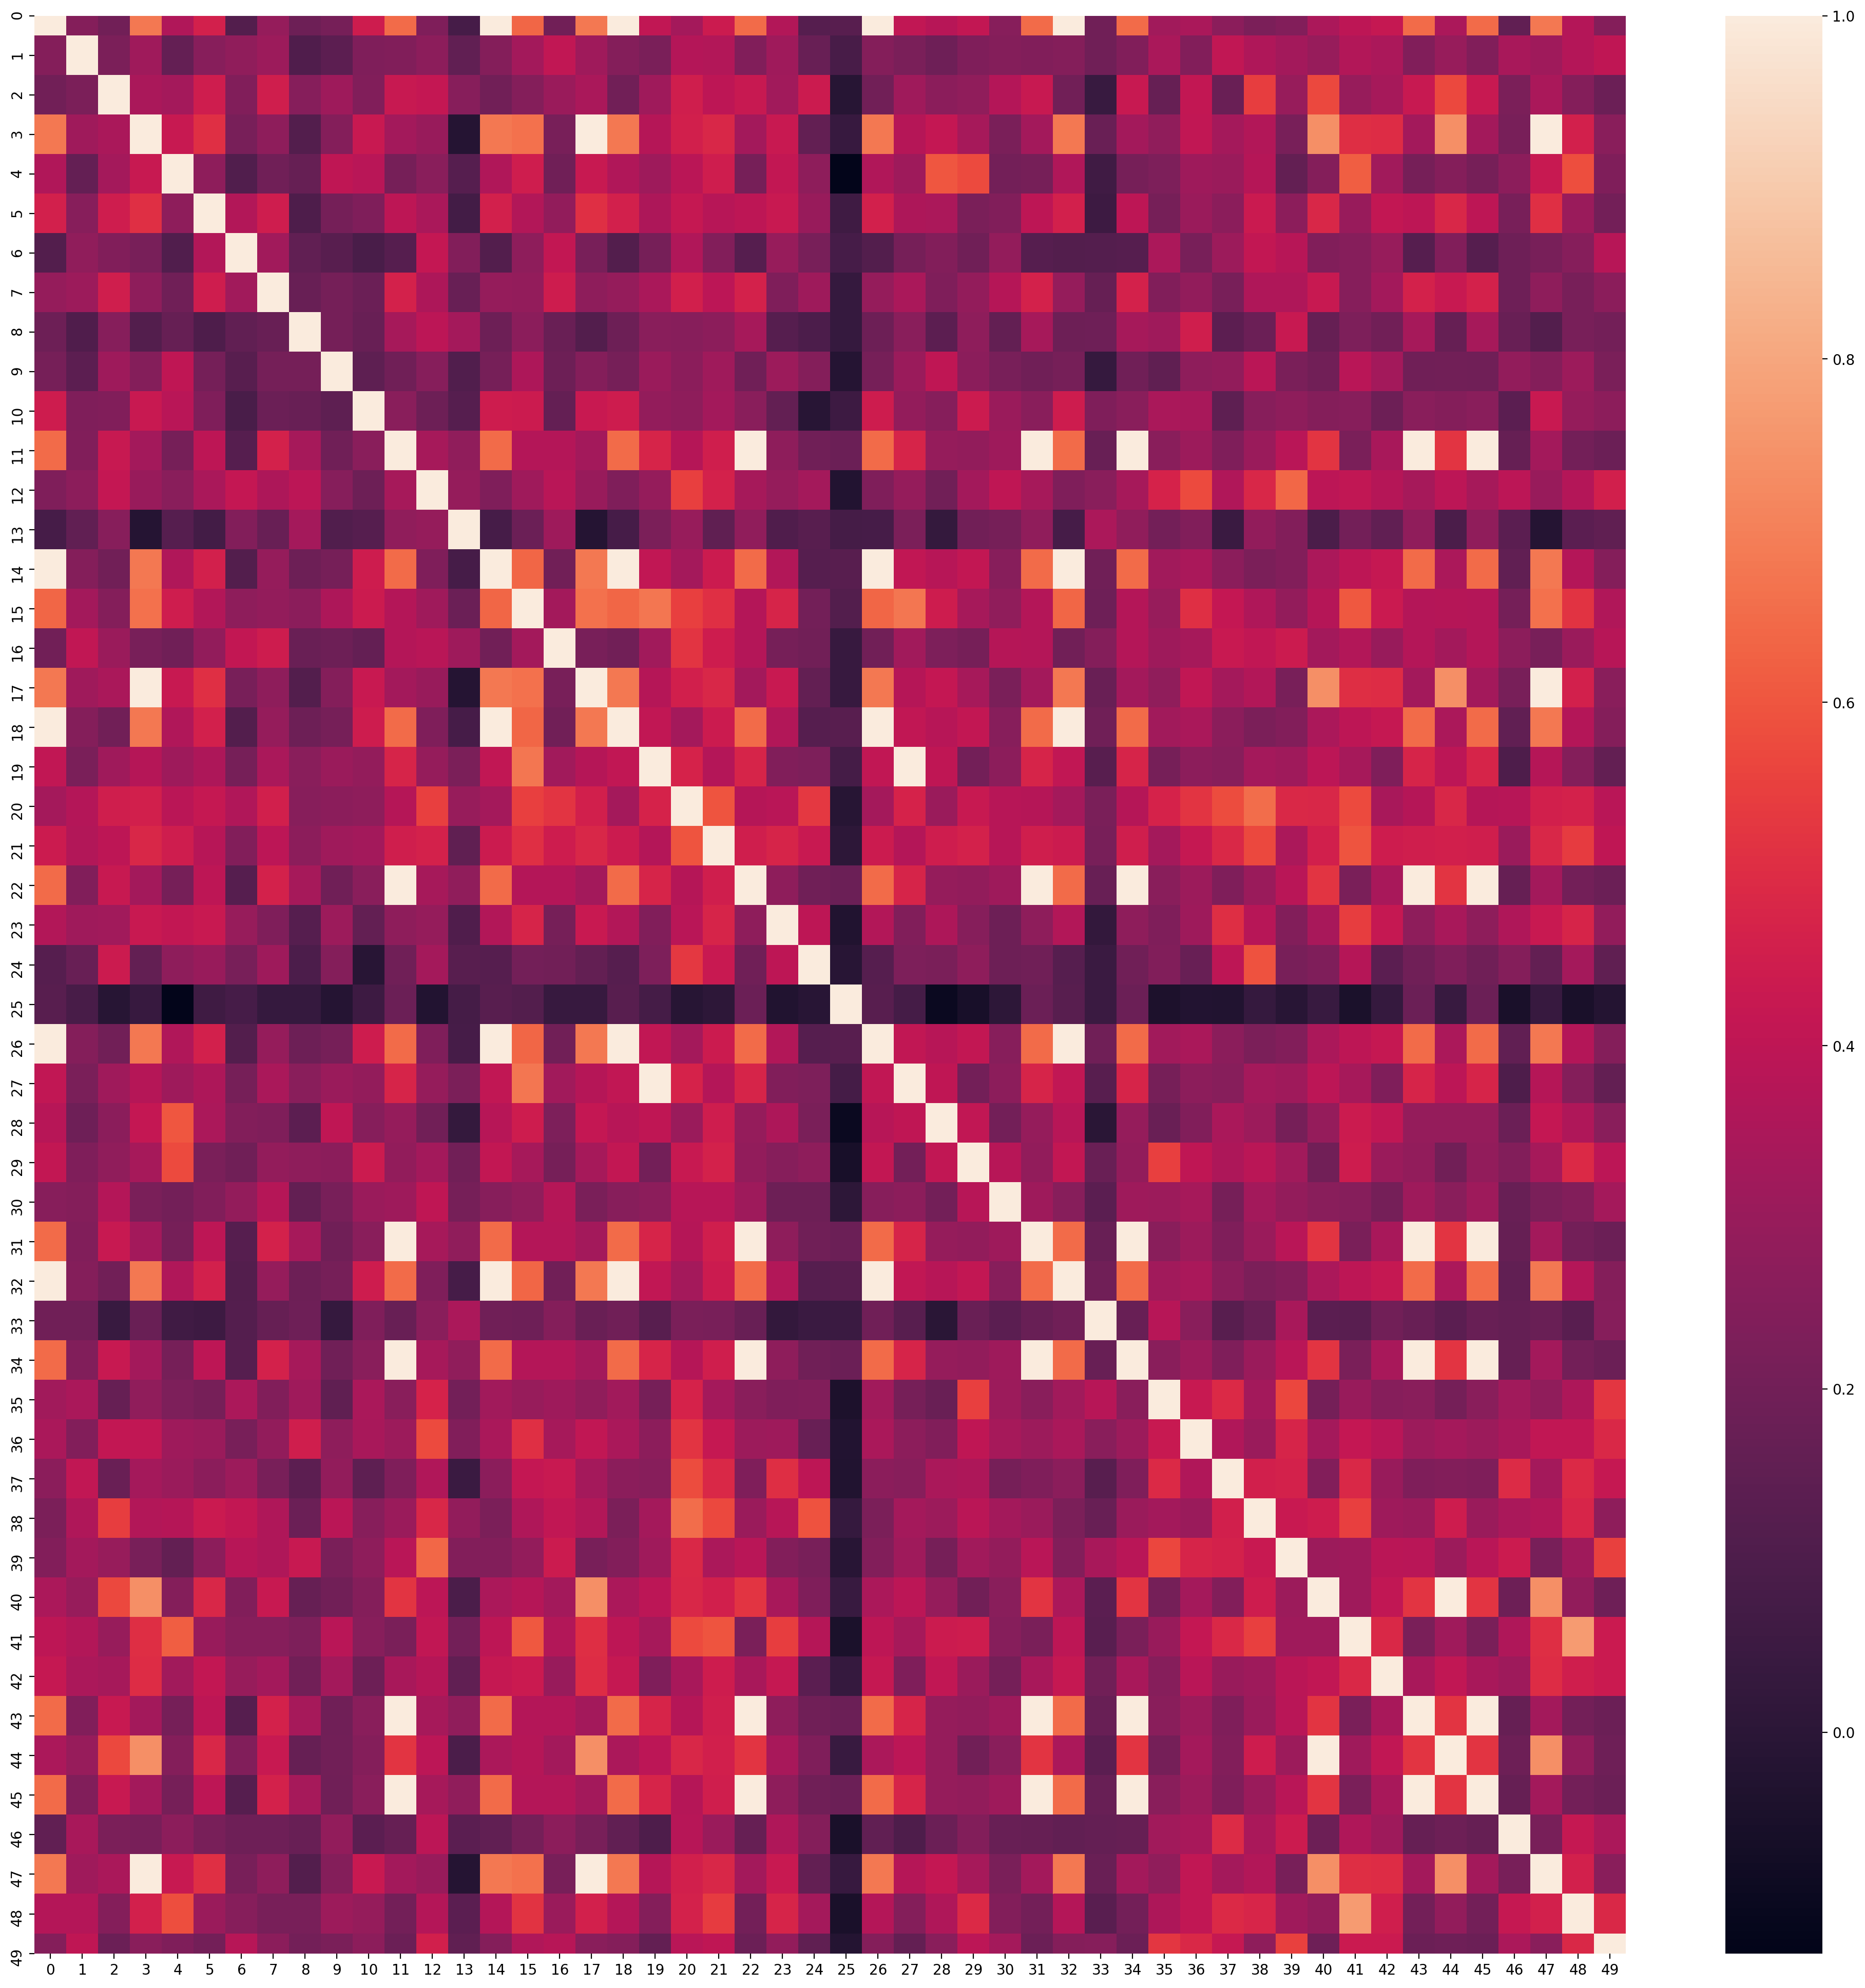

In [69]:
print("Sentence similarity by root embedding vectors.")

plt.figure(figsize=(25, 25))
sns.heatmap(root_sim_array)

Sentence similarity by verb embedding vectors.


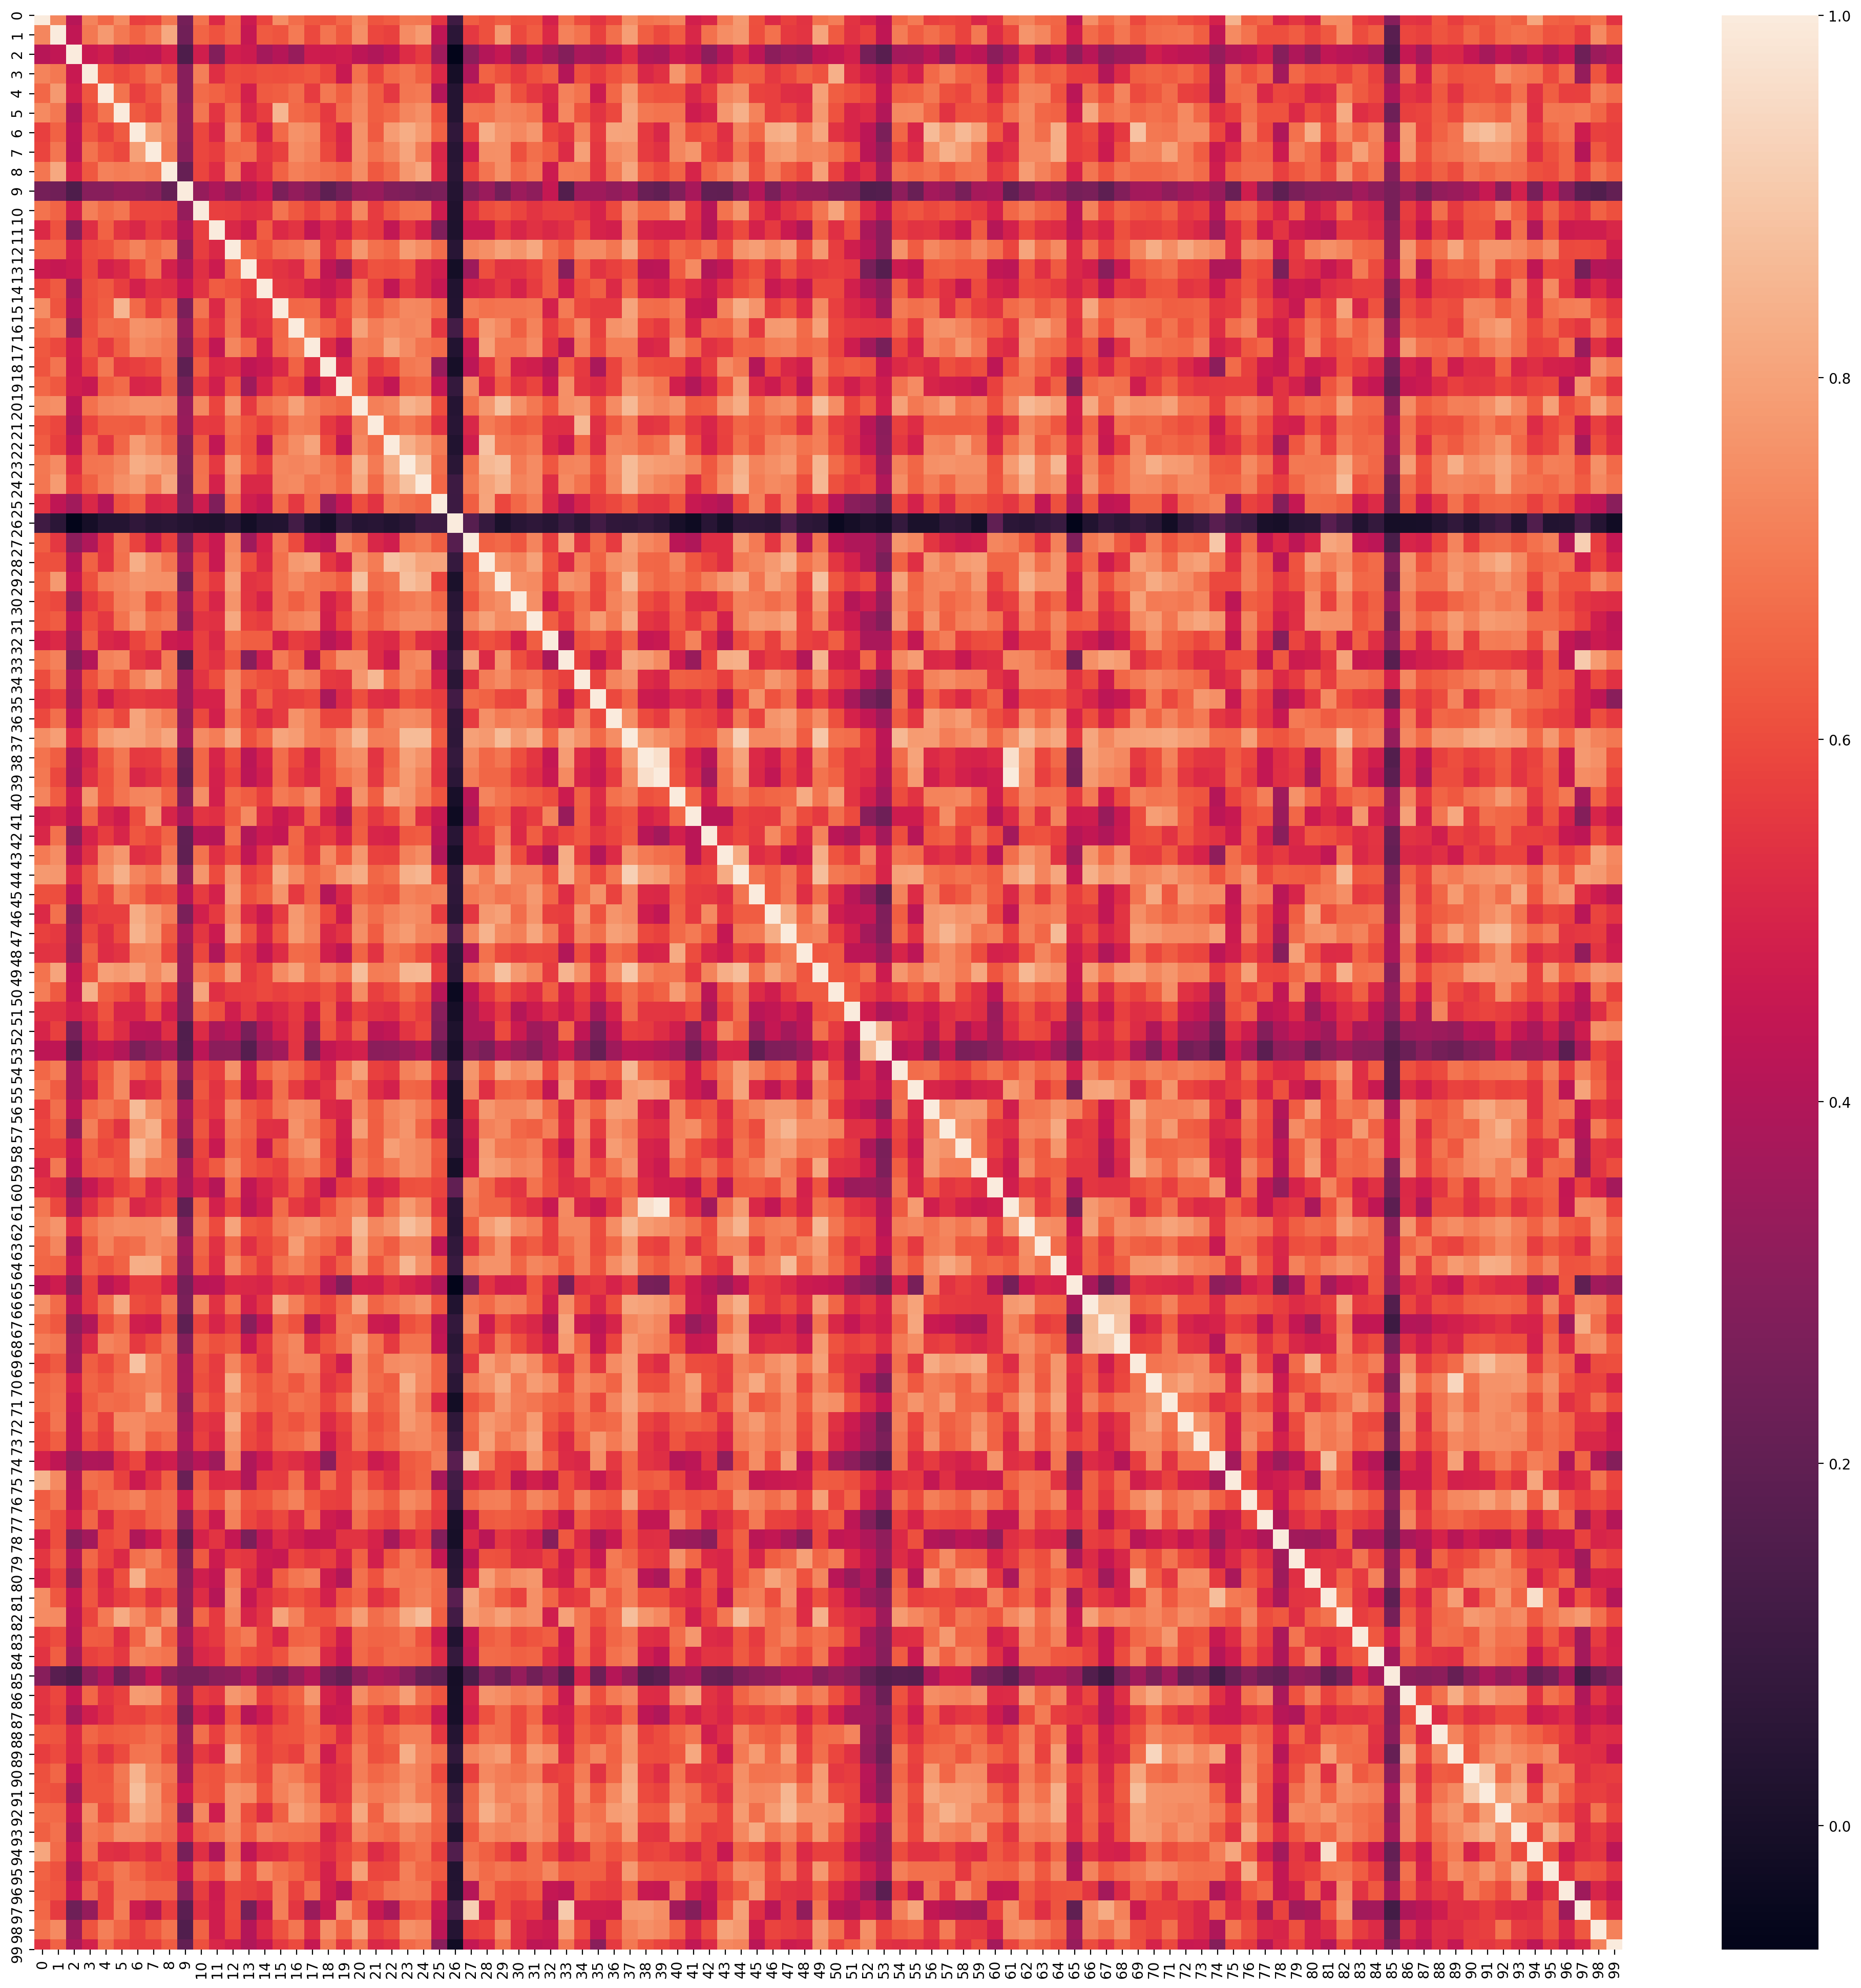

In [62]:
print("Sentence similarity by verb embedding vectors.")

plt.figure(figsize=(25, 25))
sns.heatmap(verb_sim_array)

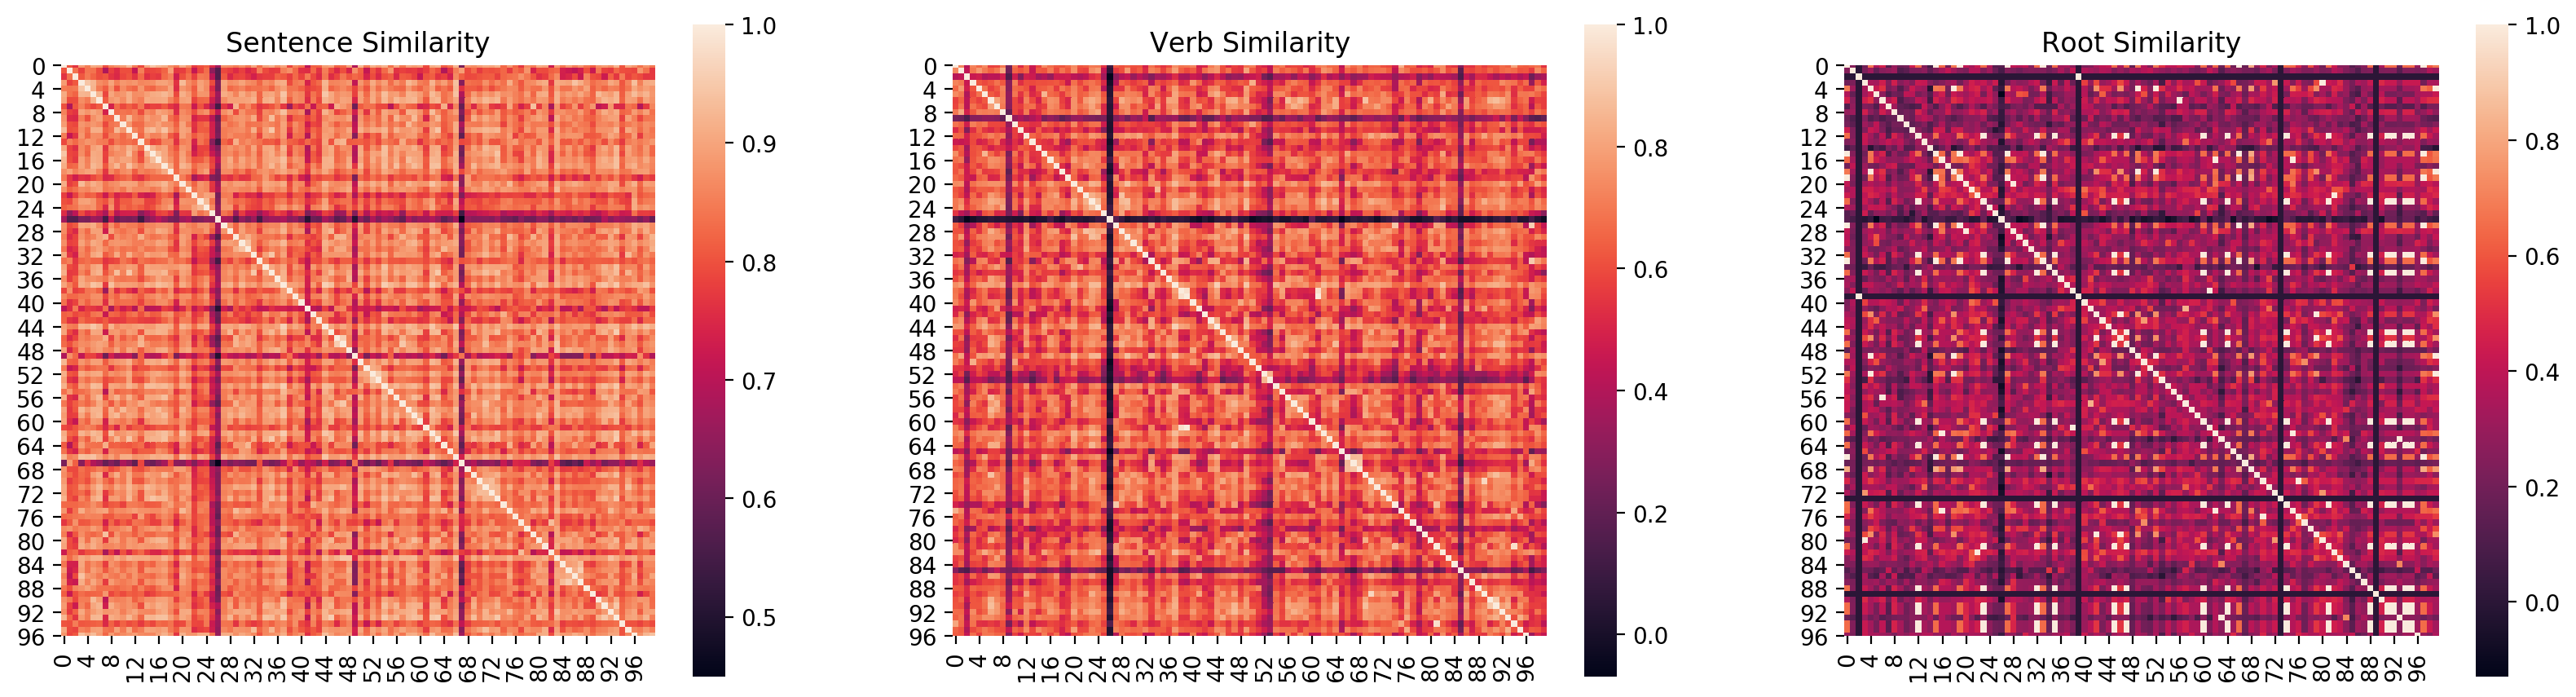

In [63]:
fig = plt.figure(figsize = (20,20))
ax1 = fig.add_subplot(3, 3, 1) # row, column, position
ax2 = fig.add_subplot(3, 3, 2)
ax3 = fig.add_subplot(3, 3, 3)

ax1.set_title('Sentence Similarity')
sns.heatmap(data=sent_sim_array, ax=ax1, square=True,  cbar_kws={'shrink': .9})

ax2.set_title('Verb Similarity')
sns.heatmap(data=verb_sim_array, ax=ax2, square=True,  cbar_kws={'shrink': .9})

ax3.set_title('Root Similarity')
sns.heatmap(data=root_sim_array, ax=ax3, square=True,  cbar_kws={'shrink': .9})

In [83]:
def print_sentence_components(spacy_sent, idx):
    
    print("Sentence: %s" % spacy_sent.text)
    print("Sentence root: %s" % spacy_sent.root.text)
    print("Sentence verbs: %s" % verb_spans[idx].text)
    print("Sentence entities: %s" % (spacy_sent.ents))


In [129]:
idx_1 = 1
idx_2 = 105

sent_1 = full_sentences[idx_1]
sent_2 = full_sentences[idx_2]
print("Sentence 1 index: %d" % idx_1)
print("Sentence 1: %s" % sent_1.text)
print("Sentence 1 root: %s" % sent_1.root.text)
print("Sentence 1 verbs: %s" % verb_spans[idx_1].text)
print("Sentence 1 entities: %s" % (sent_1.ents))
print('\n')

print("Sentence 2 index: %d" % idx_2)
print("Sentence 2: %s" % sent_2.text)
print("Sentence 2 root: %s" % sent_2.root.text )
print("Sentence 2 verbs: %s" % verb_spans[idx_2].text)
print("Sentence 2 entities: %s" % (sent_2.ents))
print('\n')

print("Sentence similarity (all sentence tokens): %f" % (sent_1.similarity(sent_2)))
print("Sentence similarity (root token)): %f" % (sent_1.root.similarity(sent_2.root)))
print("Sentence similarity (all verb tokens): %f" % (verb_spans[idx_1].similarity(verb_spans[idx_2])))

Sentence 1 index: 1
Sentence 1: during the past 2 yr, 243 strains of salmonella were isolated from 2,040 samples (11.9%) from turkey farms, including 32.5% (52/160) from the intestines of 12-day-old turkey poults, 14.2% (119/840) from feces collected from the turkey growing periods, and 6.9% (72/1,040) from finishing periods.
Sentence 1 root: isolated
Sentence 1 verbs: were isolated including collected growing finishing
Sentence 1 entities: [salmonella, turkey, turkey, feces, turkey]


Sentence 2 index: 105
Sentence 2: escherichia coli o157:nm was isolated from stools and from a tomato and cheese salad prepared at the school canteen where the teenager attended.
Sentence 2 root: isolated
Sentence 2 verbs: was isolated prepared attended
Sentence 2 entities: [escherichia coli, tomato, cheese, school]


Sentence similarity (all sentence tokens): 0.803321
Sentence similarity (root token)): 1.000000
Sentence similarity (all verb tokens): 0.760653


In [116]:
def get_dep_path_to_lca(sent, ent_token, lca_node):

    polarity = 1
    current_node = ent_token
    nodes_in_path = []
    while current_node not in [lca_node, sent.root]:
        for child in current_node.children:
            if child.dep_ == 'NEG':
                polarity = polarity * -1

        nodes_in_path.append(current_node)
        current_node = current_node.head

    if polarity == 1:
        return nodes_in_path
    else:
        return 0

def get_dep_path_between_entities(sent, ent_1, ent_2):

    lca_node_idx = penemuu.TestFunctions.get_lca_idx_of_ent_pair(sent, (ent_1, ent_2))
    lca_node = sent[lca_node_idx]

    ent_1_path_to_lca = get_dep_path_to_lca(sent, ent_1, lca_node)
    ent_2_path_to_lca = get_dep_path_to_lca(sent, ent_2, lca_node)

    result = {
        'ent_1_path_to_lca': ent_1_path_to_lca,
        'ent_2_path_to_lca': ent_2_path_to_lca,
        'lca_node_path_to_root': [],
        'polarity': 1,
    }
    if ent_1_path_to_lca != 0 and ent_2_path_to_lca != 0:
        current_node = lca_node
        while current_node != sent.root:
            for child in current_node.children:
                if child.dep_ == 'NEG':
                    result['polarity'] = result['polarity'] * -1

            current_node = current_node.head

    return result

In [127]:
test_sent = full_sentences[105]

ent_pairs = TestFunctions.get_entity_pairs(test_sent, 'BACTERIA', 'HABITAT')

for ent_pair in ent_pairs:
    
    ent_1_idx = TestFunctions.get_entity_token_idx(test_sent, ent_pair[0])
    ent_2_idx = TestFunctions.get_entity_token_idx(test_sent, ent_pair[1])

    lca_idx = TestFunctions.get_lca_idx_of_ent_pair(test_sent, ent_pair)
    lca_node = test_sent[lca_idx]
    dep_paths = get_dep_path_between_entities(test_sent, ent_pair[0], ent_pair[1])

print(test_sent)
print(dep_path)
print(test_sent.root)

escherichia coli o157:nm was isolated from stools and from a tomato and cheese salad prepared at the school canteen where the teenager attended.
{'ent_1_path_to_lca': [s. flexneri], 'ent_2_path_to_lca': [swine, sample, from], 'lca_node_path_to_root': [], 'polarity': 1}
isolated


In [128]:

for node in dep_paths['ent_1_path_to_lca']:
    print(node, node.dep_)

print('\n')
for node in dep_paths['ent_2_path_to_lca']:
    print(node, node.dep_)
displacy.render(test_sent)

escherichia coli nsubjpass


school compound
canteen pobj
at prep
prepared acl
salad pobj
from conj
from prep


In [107]:
"""
Clustering methods
"""

from sklearn.cluster import DBSCAN

dens_scan = DBSCAN(eps=0.1, min_samples=1).fit_predict(verb_sim_array)

print("Density scan cluster assignments:")
print(dens_scan)

dens_scan_result = np.where(dens_scan == 73)

for i in dens_scan_result[0]:
    print(i)
    print(full_sentences[i])
    print('Root = %s' % full_sentences[i].root)
    print('Verbs = %s' % (sorted(verb_spans[i].text.split(' '))))
    print('\n')

Density scan cluster assignments:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  39  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111  18 112 113 114 115 116 117 118 119 120 121 122 123
 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159
 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177
 178 179 180 181 182 183 184 185 186 187 188 189 190  73 191 192 193  73
 194 195 196 197 198 199 200 201 202 203  47 204 205 206 207 131 208 209
 210 211 212 213 214 215 216 217 218 219 220 221 222  73 223 224 225 226
 227 228 229 230 

Sentence similarity by averaged word embedding vectors (clustered).


<Figure size 24000x24000 with 0 Axes>

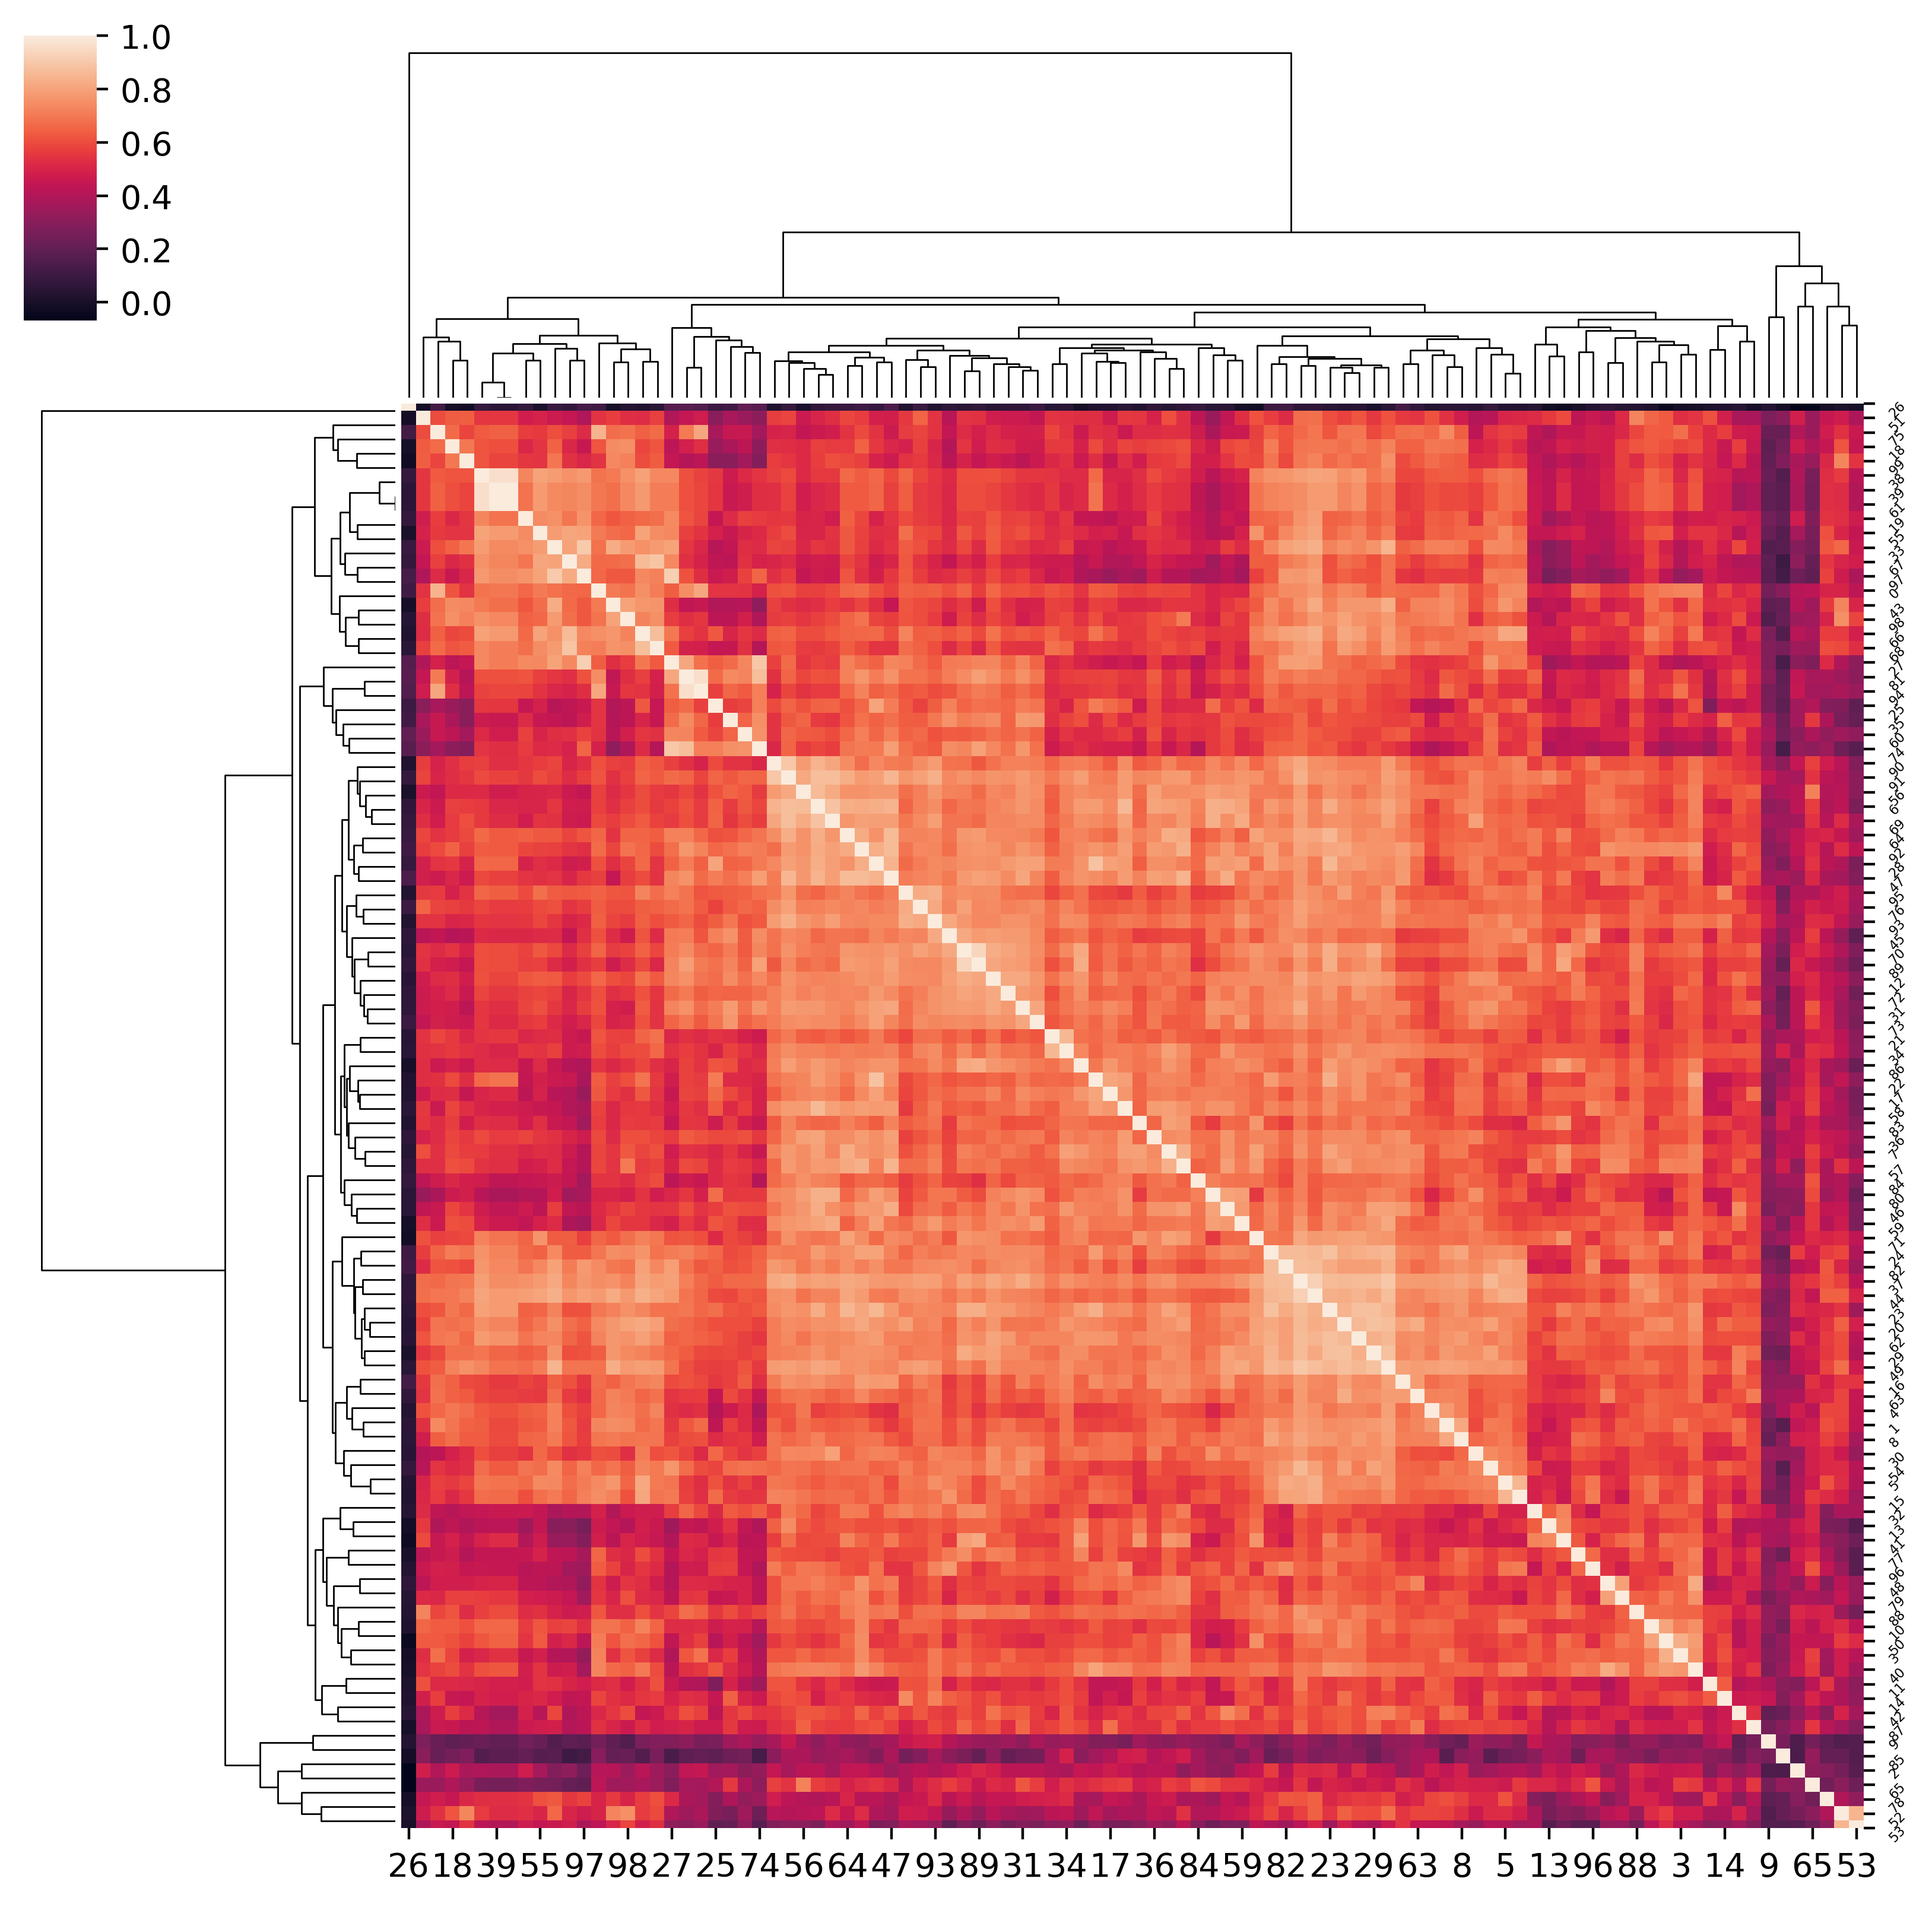

In [82]:
print("Sentence similarity by averaged word embedding vectors (clustered).")

plt.figure(figsize=(60, 60))
g = sns.clustermap(verb_sim_array, yticklabels=1)
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=45, size=4)
plt.show()

In [109]:
full_sentences[0]

the aim of this study was to investigate the prevalence of antimicrobial resistance of salmonella isolated from turkey farms in taiwan.

22

In [115]:
test_sentence = full_sentences[0]

sentence_ent_pairs = TestFunctions.get_entity_pairs(test_sentence, 'BACTERIA', 'HABITAT')

for ent_pair in sentence_ent_pairs:
    lca_idx = TestFunctions.get_lca_idx_of_ent_pair(test_sentence, ent_pair)
    lca_node = test_sentence[lca_idx]
    

prevalence


In [118]:
for left in lca_node.rights:
    print(left)

of
isolated


In [122]:
full_sentences[0].root.i - full_sentences[0].start

5

In [139]:
"""
Entity direction from LCA

Bac Left Hab Right
Bac Left Hab Left
Bac Right Hab Left
Bac Right Hab Right
"""

for sentence in full_sentences[:20]:
    
    ent_pairs = TestFunctions.get_entity_pairs(sentence, 'BACTERIA', 'HABITAT')
    
    for ent_pair in ent_pairs:
        
        bac_idx = ent_pair[0].i - sentence.start
        hab_idx = ent_pair[1].i - sentence.start        
        lca_idx = TestFunctions.get_lca_idx_of_ent_pair(sentence, ent_pair)
        lca_node = sentence[lca_idx]

        sorted_sequence = (sorted([bac_idx, hab_idx, lca_idx]))
        
        if lca_idx == sorted_sequence[0]:
            directions = 'BRHR' 
        elif lca_idx == sorted_sequence[-1]:
            directions = 'BLHL'
        elif bac_idx < hab_idx:
            directions = 'BLHR'
        elif bac_idx > hab_idx:
            directions = 'BRHL'
        else:
            print(sentence)
            print(ent_pair)
            
        if lca_node.pos_ in ['VERB', 'AUX']:
            print(sentence)
            print(lca_node)
            print(ent_pair, bac_idx, hab_idx, lca_idx)
            print(sorted_sequence)

            print(directions)
            print('\n')
            

during the past 2 yr, 243 strains of salmonella were isolated from 2,040 samples (11.9%) from turkey farms, including 32.5% (52/160) from the intestines of 12-day-old turkey poults, 14.2% (119/840) from feces collected from the turkey growing periods, and 6.9% (72/1,040) from finishing periods.
isolated
(salmonella, turkey) 9 20 11
[9, 11, 20]
BLHR


during the past 2 yr, 243 strains of salmonella were isolated from 2,040 samples (11.9%) from turkey farms, including 32.5% (52/160) from the intestines of 12-day-old turkey poults, 14.2% (119/840) from feces collected from the turkey growing periods, and 6.9% (72/1,040) from finishing periods.
isolated
(salmonella, turkey) 9 36 11
[9, 11, 36]
BLHR


during the past 2 yr, 243 strains of salmonella were isolated from 2,040 samples (11.9%) from turkey farms, including 32.5% (52/160) from the intestines of 12-day-old turkey poults, 14.2% (119/840) from feces collected from the turkey growing periods, and 6.9% (72/1,040) from finishing periods

In [131]:
counted_verb_lemmas_used

[('be', 608),
 ('show', 62),
 ('use', 55),
 ('isolate', 51),
 ('detect', 50),
 ('investigate', 50),
 ('identify', 46),
 ('find', 35),
 ('report', 35),
 ('indicate', 30),
 ('cause', 29),
 ('suggest', 28),
 ('reveal', 27),
 ('provide', 25),
 ('demonstrate', 25),
 ('evaluate', 22),
 ('associate', 22),
 ('describe', 21),
 ('have', 20),
 ('collect', 20),
 ('examine', 19),
 ('observe', 19),
 ('test', 18),
 ('perform', 15),
 ('highlight', 15),
 ('develop', 15),
 ('characterize', 14),
 ('determine', 14),
 ('conduct', 13),
 ('contaminate', 13),
 ('confirm', 13),
 ('analyze', 12),
 ('compare', 12),
 ('carry', 12),
 ('represent', 11),
 ('result', 11),
 ('assess', 11),
 ('include', 11),
 ('require', 10),
 ('aim', 10),
 ('understand', 10),
 ('consider', 10),
 ('need', 10),
 ('exhibit', 9),
 ('lead', 8),
 ('increase', 8),
 ('apply', 8),
 ('recognize', 8),
 ('obtain', 8),
 ('inoculate', 8),
 ('pose', 8),
 ('present', 8),
 ('occur', 7),
 ('select', 7),
 ('strain', 7),
 ('reduce', 7),
 ('trace', 7),
 (

In [1]:
import re


class POSPatternFinder(object):
    
    def __init__(self):
        self.pos_patterns = []
        
        
        
    
    

In [2]:
sentence

NameError: name 'sentence' is not defined